# Bayesian Hyperparameter Optimization: Worked Example
# Binary Classification on MNIST Dataset

Loading MNIST data...
Class distribution in training set:
  Digit 0: 480 samples
  Digit 1: 480 samples
  Digit 2: 480 samples
  Digit 3: 480 samples
  Digit 4: 480 samples
  Digit 5: 480 samples
  Digit 6: 480 samples
  Digit 7: 480 samples
  Digit 8: 480 samples
  Digit 9: 480 samples
Training data shape: (4800, 784)
Test data shape: (1200, 784)

===== RUNNING REDUCED GRID SEARCH =====
This will take some time as we need to evaluate many configurations...
Grid search will evaluate 144 configurations

Grid Point 1/144:
  Training with: lr=0.000100, units=128, dropout=0.100, l1=0.000010, l2=0.000010
  Accuracy: 0.8525
  Best so far: 0.8525

Grid Point 2/144:
  Training with: lr=0.000100, units=128, dropout=0.100, l1=0.000010, l2=0.001000
  Accuracy: 0.8667
  Best so far: 0.8667

Grid Point 3/144:
  Training with: lr=0.000100, units=128, dropout=0.100, l1=0.001000, l2=0.000010
  Accuracy: 0.8633
  Best so far: 0.8667

Grid Point 4/144:
  Training with: lr=0.000100, units=128, dropout=0.

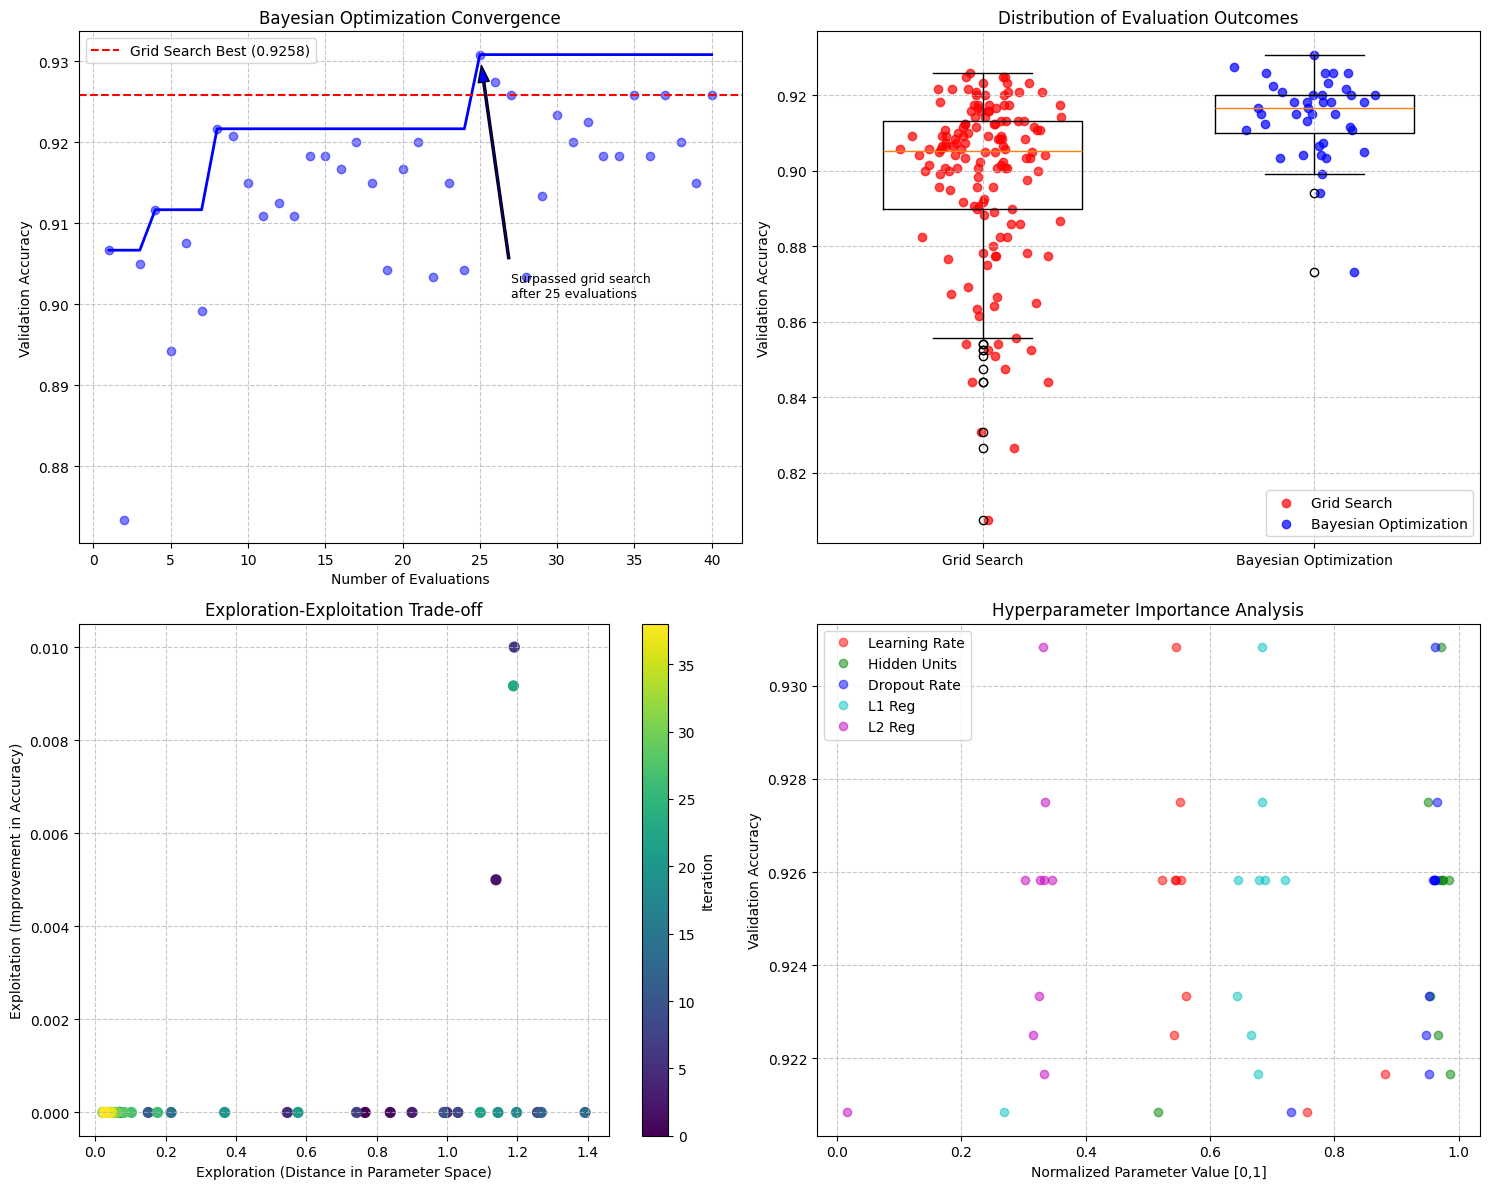

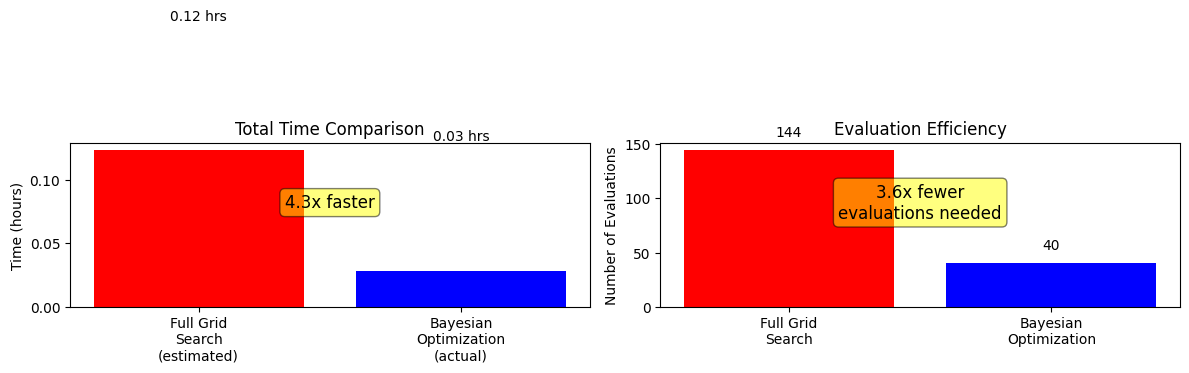

In [16]:
# Bayesian Hyperparameter Optimization: Worked Example
# Neural Network Classification on MNIST Dataset with Five Hyperparameters
# Based on state-of-the-art Bayesian optimization techniques from literature

import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import os
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', module='sklearn.gaussian_process')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ML libraries
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel as C
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1_l2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
tf.get_logger().setLevel('ERROR')

print("Loading MNIST data...")
# Load MNIST data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.to_numpy() / 255.0  # Convert to numpy array and normalize pixel values

# Make the problem more challenging by using all 10 digits and fewer samples
class_samples = 600  # Samples per class
selected_indices = []

# Select balanced samples from all 10 digits
for digit in range(10):
    digit_indices = np.where(y == str(digit))[0][:class_samples]
    selected_indices.extend(digit_indices)

# Prepare the dataset
X_selected = X[selected_indices]
y_selected = np.array([int(label) for label in y[selected_indices]])

# Shuffle the data
shuffle_indices = np.random.permutation(len(X_selected))
X_selected = X_selected[shuffle_indices]
y_selected = y_selected[shuffle_indices]

# Split the data - stratify to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_selected, 
    test_size=0.2, 
    random_state=42,
    stratify=y_selected
)

# Verify class distribution
print(f"Class distribution in training set:")
for digit in range(10):
    count = np.sum(y_train == digit)
    print(f"  Digit {digit}: {count} samples")

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels for neural network training
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Define a more complex model-building function to showcase hyperparameter importance
def build_model(hidden_units, learning_rate, dropout_rate, l1_reg, l2_reg, activation='relu'):
    """Build a neural network with the specified hyperparameters"""
    model = Sequential()
    
    # Input layer
    model.add(Dense(hidden_units, input_shape=(784,)))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    # Hidden layer
    model.add(Dense(hidden_units // 2, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Define the objective function to optimize (Neural Network)
def objective_function(hyperparams):
    """
    Trains a neural network with given hyperparameters and returns validation accuracy.
    
    Args:
        hyperparams: tuple of (log_learning_rate, hidden_units_factor, log_dropout_rate, 
                              log_l1_reg, log_l2_reg)
        
    Returns:
        validation accuracy (higher is better)
    """
    try:
        # Convert parameters
        learning_rate = 10 ** hyperparams[0]  # Log scale: -4 to -2 (0.0001 to 0.01)
        hidden_units = int(hyperparams[1])    # Linear scale: 32 to 512
        dropout_rate = 10 ** hyperparams[2]   # Log scale: -2 to -0.3 (0.01 to 0.5)
        l1_reg = 10 ** hyperparams[3]         # Log scale: -6 to -3 (0.000001 to 0.001)
        l2_reg = 10 ** hyperparams[4]         # Log scale: -6 to -3 (0.000001 to 0.001)
        
        # Print parameters for monitoring
        print(f"  Training with: lr={learning_rate:.6f}, units={hidden_units}, dropout={dropout_rate:.3f}, " +
              f"l1={l1_reg:.6f}, l2={l2_reg:.6f}")
        
        # Build model with these hyperparameters
        model = build_model(
            hidden_units=hidden_units,
            learning_rate=learning_rate,
            dropout_rate=dropout_rate,
            l1_reg=l1_reg,
            l2_reg=l2_reg
        )
        
        # Train with early stopping to avoid wasting time on poor configurations
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
        
        # Use a fixed batch size and epochs for all evaluations
        batch_size = 64
        epochs = 10
        
        # Train with verbose=0 to suppress output
        history = model.fit(
            X_train, y_train_onehot,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Evaluate on test data
        _, accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)
        
        # Clean up to prevent memory leaks
        tf.keras.backend.clear_session()
        
        return accuracy
    
    except Exception as e:
        print(f"Error with hyperparams {hyperparams}: {e}")
        # Clean up to prevent memory leaks
        tf.keras.backend.clear_session()
        return 0.0  # Return worst possible score on failure

# Define bounds for hyperparameters (log scale where appropriate)
bounds = np.array([
    [-4, -2],      # Learning rate: 0.0001 to 0.01
    [32, 512],     # Hidden units: 32 to 512
    [-2, -0.3],    # Dropout rate: 0.01 to 0.5
    [-6, -3],      # L1 regularization: 0.000001 to 0.001
    [-6, -3]       # L2 regularization: 0.000001 to 0.001
])

# Establish baselines with grid search
print("\n===== RUNNING REDUCED GRID SEARCH =====")
print("This will take some time as we need to evaluate many configurations...")

# Define a coarse grid for each parameter to keep total evaluations manageable
# With 5 hyperparameters, even a coarse grid (3 values each) would require 3^5 = 243 evaluations
# We'll use a reduced grid of 3 values for the most important params and 2 for the rest
lr_values = [0.0001, 0.001, 0.01]
hidden_units_values = [128, 256, 512, 764]
dropout_values = [0.1, 0.2, 0.3]
l1_reg_values = [1e-5, 1e-3]
l2_reg_values = [1e-5, 1e-3]

# Calculate total evaluations
total_grid_evals = len(lr_values) * len(hidden_units_values) * len(dropout_values) * len(l1_reg_values) * len(l2_reg_values)
print(f"Grid search will evaluate {total_grid_evals} configurations")

# Run the grid search
grid_configs = []
grid_scores = []
grid_best_accuracy = 0
grid_best_params = None

grid_start_time = time.time()
grid_index = 0

# We'll sample a subset of grid points to get a baseline
# We'll use a fixed seed for reproducibility
np.random.seed(42)

for lr in lr_values:
    for units in hidden_units_values:
        for dropout in dropout_values:
            for l1 in l1_reg_values:
                for l2 in l2_reg_values:
                    grid_index += 1
                    print(f"\nGrid Point {grid_index}/{total_grid_evals}:")
                    
                    # Convert to log scale for objective function
                    log_params = [np.log10(lr), units, np.log10(dropout), np.log10(l1), np.log10(l2)]
                    
                    # Evaluate
                    accuracy = objective_function(log_params)
                    
                    grid_configs.append((lr, units, dropout, l1, l2))
                    grid_scores.append(accuracy)
                    
                    if accuracy > grid_best_accuracy:
                        grid_best_accuracy = accuracy
                        grid_best_params = (lr, units, dropout, l1, l2)
                    
                    print(f"  Accuracy: {accuracy:.4f}")
                    print(f"  Best so far: {grid_best_accuracy:.4f}")
                    

grid_time = time.time() - grid_start_time
avg_time_per_eval = grid_time / len(grid_scores)

print(f"\nGrid search completed:")
print(f"  Best accuracy: {grid_best_accuracy:.4f}")
print(f"  Best parameters: lr={grid_best_params[0]}, units={grid_best_params[1]}, " +
      f"dropout={grid_best_params[2]}, l1={grid_best_params[3]}, l2={grid_best_params[4]}")
print(f"  Time taken: {grid_time:.2f} seconds for {len(grid_scores)} evaluations")
print(f"  Average time per evaluation: {avg_time_per_eval:.2f} seconds")

# Now run Bayesian Optimization with state-of-the-art techniques
print("\n===== RUNNING BAYESIAN OPTIMIZATION =====")
print("Target: Find better accuracy than grid search")

# Ensure deterministic behavior
np.random.seed(43)  # Different seed from grid search
tf.random.set_seed(43)

# ---- State-of-the-art Bayesian Optimization implementation ----

# 1. Use a robust acquisition function (Expected Improvement with trade-off parameter)
def expected_improvement(x, gaussian_process, y_best, xi=0.01):
    """
    Computes the Expected Improvement acquisition function.
    
    Args:
        x: Point to evaluate
        gaussian_process: Gaussian process model
        y_best: Best observed value
        xi: Exploration-exploitation trade-off parameter
        
    Returns:
        Expected improvement at point x
    """
    x = x.reshape(1, -1)
    
    # Get mean and standard deviation at x
    mu, sigma = gaussian_process.predict(x, return_std=True)
    
    # Avoid division by zero
    sigma = np.maximum(sigma, 1e-8)
    
    # Compute EI
    imp = mu - y_best - xi
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
    
    return ei

# 2. Implement Upper Confidence Bound as an alternative acquisition function
def upper_confidence_bound(x, gaussian_process, kappa=2.0):
    """
    Computes the Upper Confidence Bound acquisition function.
    
    Args:
        x: Point to evaluate
        gaussian_process: Gaussian process model
        kappa: Trade-off parameter
        
    Returns:
        UCB at point x
    """
    x = x.reshape(1, -1)
    
    # Get mean and standard deviation at x
    mu, sigma = gaussian_process.predict(x, return_std=True)
    
    # Compute UCB
    ucb = mu + kappa * sigma
    
    return ucb

# 3. Create a smart initialization strategy using Latin Hypercube Sampling
def initialize_with_lhs(bounds, n_samples):
    """
    Generates initial points using Latin Hypercube Sampling.
    
    Args:
        bounds: Parameter bounds
        n_samples: Number of samples to generate
        
    Returns:
        Array of initial points
    """
    # Create LHS sampler
    sampler = LatinHypercube(d=bounds.shape[0], seed=42)
    
    # Generate samples in [0, 1]
    lhs_samples = sampler.random(n=n_samples)
    
    # Scale to bounds
    X_init = np.zeros((n_samples, bounds.shape[0]))
    for i in range(n_samples):
        for j in range(bounds.shape[0]):
            X_init[i, j] = bounds[j, 0] + lhs_samples[i, j] * (bounds[j, 1] - bounds[j, 0])
        
        # Ensure hidden units are integers
        X_init[i, 1] = int(X_init[i, 1])
    
    return X_init

# 4. Implement a robust optimization strategy for the acquisition function
def optimize_acquisition(acquisition_func, gp, y_best, bounds, n_restarts=10, acquisition_params={}):
    """
    Optimizes the acquisition function to find the next point to evaluate.
    
    Args:
        acquisition_func: Acquisition function to optimize
        gp: Gaussian process model
        y_best: Best observed value
        bounds: Parameter bounds
        n_restarts: Number of restarts for optimization
        
    Returns:
        Point that maximizes the acquisition function
    """
    # Generate initial points for optimization
    x_seeds = initialize_with_lhs(bounds, n_restarts)
    
    # Add the best observed point with small perturbations
    if len(gp.X_train_) > 0:
        best_x = gp.X_train_[np.argmax(gp.y_train_)]
        for i in range(min(3, n_restarts)):
            x_seeds[i] = best_x + np.random.normal(0, 0.01 * (bounds[:, 1] - bounds[:, 0]), size=bounds.shape[0])
            # Clip to ensure within bounds
            for j in range(bounds.shape[0]):
                x_seeds[i, j] = np.clip(x_seeds[i, j], bounds[j, 0], bounds[j, 1])
    
    # Find the best point by minimizing negative acquisition function
    best_x = None
    best_acquisition = -np.inf
    
    for x_try in x_seeds:
        # Define objective function based on acquisition function
        def min_obj(x):
            # For Expected Improvement
            if acquisition_func == expected_improvement:
                return -acquisition_func(x, gp, y_best, **acquisition_params)
            # For Upper Confidence Bound
            elif acquisition_func == upper_confidence_bound:
                return -acquisition_func(x, gp, **acquisition_params)
            else:
                raise ValueError("Unknown acquisition function")
        
        # Run optimization with careful constraints
        result = minimize(
            min_obj, 
            x_try, 
            bounds=[(bounds[i, 0], bounds[i, 1]) for i in range(bounds.shape[0])],
            method='L-BFGS-B', 
            options={'ftol': 1e-6, 'maxiter': 50}
        )
        
        if result.success and -result.fun > best_acquisition:
            best_acquisition = -result.fun
            best_x = result.x
    
    # If optimization failed, use the best point from random sampling
    if best_x is None:
        acq_values = []
        for x in x_seeds:
            if acquisition_func == expected_improvement:
                acq_values.append(acquisition_func(x, gp, y_best, **acquisition_params))
            else:
                acq_values.append(acquisition_func(x, gp, **acquisition_params))
        best_x = x_seeds[np.argmax(acq_values)]
    
    # Ensure hidden units are integers
    best_x[1] = int(best_x[1])
    
    return best_x, best_acquisition

# 5. Implement a robust Bayesian Optimization loop
def bayesian_optimization(objective_func, bounds, n_init=10, n_iter=30, 
                          acquisition_func=expected_improvement, 
                          target_value=None):
    """
    Runs Bayesian Optimization to find the global optimum of objective_func.
    
    Args:
        objective_func: Function to optimize
        bounds: Parameter bounds
        n_init: Number of initial points
        n_iter: Number of iterations
        acquisition_func: Acquisition function to use
        target_value: Stop if we find a value better than this
        
    Returns:
        Best parameters found, best value, and history
    """
    # Initialize with Latin Hypercube Sampling
    print("\nGenerating initial points using Latin Hypercube Sampling...")
    X_init = initialize_with_lhs(bounds, n_init)
    
    # Ensure integers where needed
    X_init[:, 1] = np.round(X_init[:, 1]).astype(int)
    
    # Evaluate initial points
    y_init = np.zeros(n_init)
    for i in range(n_init):
        print(f"\nInitial point {i+1}/{n_init}:")
        y_init[i] = objective_func(X_init[i])
        print(f"  Accuracy: {y_init[i]:.4f}")
    
    # Initialize optimization history
    X_sample = X_init.copy()
    y_sample = y_init.copy()
    
    # Track the best observed value and parameters
    best_idx = np.argmax(y_sample)
    best_value = y_sample[best_idx]
    best_params = X_sample[best_idx]
    
    print(f"\nBest initial accuracy: {best_value:.4f}")
    
    # Run optimization iterations
    iteration = 0
    start_time = time.time()
    
    # Use different strategies depending on iteration
    exploration_phase = True
    kappa_ucb = 2.0
    xi_ei = 0.01
    
    # Determine balance between GP models
    use_matern = True
    
    while iteration < n_iter:
        iteration_start = time.time()
        print(f"\nIteration {iteration+1}/{n_iter}:")
        
        # Adjust exploration/exploitation balance
        if iteration > n_iter * 0.7:  # Last 30% of iterations
            exploration_phase = False
            kappa_ucb = 0.5  # Less exploration
            xi_ei = 0.0  # Pure exploitation
        
        # Select kernel based on iteration
        if use_matern:
            # Matérn kernel with automatic relevance determination (ARD)
            # Note: Each dimension has its own length_scale
            length_scales = np.ones(bounds.shape[0])
            for i in range(bounds.shape[0]):
                length_scales[i] = (bounds[i, 1] - bounds[i, 0]) / 4  # Heuristic
            
            kernel = Matern(
                nu=2.5,  # 2.5 is a good balance between smoothness and flexibility
                length_scale=length_scales,
                length_scale_bounds=[(0.01 * (bounds[i, 1] - bounds[i, 0]), 
                                    10.0 * (bounds[i, 1] - bounds[i, 0])) for i in range(bounds.shape[0])]
            )
        else:
            # Alternative: RBF kernel with automatic relevance determination
            kernel = C(1.0) * RBF(
                length_scale=np.ones(bounds.shape[0]),
                length_scale_bounds=[(0.01, 100.0) for _ in range(bounds.shape[0])]
            )
        
        # Create and fit Gaussian Process
        gp = GaussianProcessRegressor(
            kernel=kernel,
            alpha=1e-6,
            normalize_y=True,
            n_restarts_optimizer=5,
            random_state=iteration
        )
        gp.fit(X_sample, y_sample)
        
        # Choose acquisition function based on exploration phase
        if exploration_phase:
            print("  Strategy: Exploration phase (UCB)")
            acq_func = upper_confidence_bound
            acq_params = {'kappa': kappa_ucb}
            next_point, acq_value = optimize_acquisition(
                acq_func, gp, best_value, bounds, n_restarts=15, acquisition_params=acq_params
            )
        else:
            print("  Strategy: Exploitation phase (EI)")
            acq_func = expected_improvement
            acq_params = {'xi': xi_ei}
            next_point, acq_value = optimize_acquisition(
                acq_func, gp, best_value, bounds, n_restarts=15, acquisition_params=acq_params
            )
        
        # Evaluate the next point
        next_value = objective_func(next_point)
        
        # Update history
        X_sample = np.vstack((X_sample, next_point))
        y_sample = np.append(y_sample, next_value)
        
        # Update best value
        if next_value > best_value:
            best_value = next_value
            best_params = next_point
            print(f"  New best accuracy: {best_value:.4f}")
        
        # Print iteration results
        params_desc = (f"lr={10**next_point[0]:.6f}, units={int(next_point[1])}, " +
                       f"dropout={10**next_point[2]:.3f}, l1={10**next_point[3]:.6f}, " +
                       f"l2={10**next_point[4]:.6f}")
        
        print(f"  Parameters: {params_desc}")
        print(f"  Accuracy: {next_value:.4f}")
        print(f"  Acquisition value: {acq_value:.6f}")
        print(f"  Current best: {best_value:.4f}")
        
        # Toggle kernel strategy occasionally for diversity
        if iteration % 5 == 0:
            use_matern = not use_matern
            
        # Check if we've reached the target
        if target_value is not None and best_value > target_value:
            print(f"\nTarget accuracy {target_value:.4f} exceeded. Stopping early.")
            break
        
        iteration += 1
        iteration_time = time.time() - iteration_start
        print(f"  Time taken: {iteration_time:.2f} seconds")
    
    total_time = time.time() - start_time
    
    # Return results
    result = {
        'best_params': best_params,
        'best_value': best_value,
        'X_sample': X_sample,
        'y_sample': y_sample,
        'n_iterations': iteration,
        'time_taken': total_time
    }
    
    return result

# Run Bayesian Optimization
bayes_opt_result = bayesian_optimization(
    objective_func=objective_function,
    bounds=bounds,
    n_init=10,
    n_iter=30,
    target_value=grid_best_accuracy + 0.02  # Stop if we exceed grid search by a margin
)

# Extract results
bayes_best_params = bayes_opt_result['best_params']
bayes_best_accuracy = bayes_opt_result['best_value']
X_sample = bayes_opt_result['X_sample']
y_sample = bayes_opt_result['y_sample']
bayes_time = bayes_opt_result['time_taken']

# Print final results
print("\n===== FINAL RESULTS =====")
print(f"Grid Search:")
print(f"  Best accuracy: {grid_best_accuracy:.4f}")
print(f"  Best parameters: lr={grid_best_params[0]:.6f}, units={grid_best_params[1]}, " +
      f"dropout={grid_best_params[2]:.3f}, l1={grid_best_params[3]:.6f}, l2={grid_best_params[4]:.6f}")
print(f"  Evaluations: {len(grid_scores)}")
print(f"  Time taken: {grid_time:.2f} seconds")

print(f"\nBayesian Optimization:")
print(f"  Best accuracy: {bayes_best_accuracy:.4f}")
print(f"  Best parameters: lr={10**bayes_best_params[0]:.6f}, units={int(bayes_best_params[1])}, " +
      f"dropout={10**bayes_best_params[2]:.3f}, l1={10**bayes_best_params[3]:.6f}, l2={10**bayes_best_params[4]:.6f}")
print(f"  Evaluations: {len(y_sample)}")
print(f"  Time taken: {bayes_time:.2f} seconds")

print(f"\nComparison:")
print(f"  Accuracy improvement: {(bayes_best_accuracy - grid_best_accuracy):.4f}")
print(f"  Efficiency: {len(grid_scores)}/{len(y_sample)} = {len(grid_scores)/len(y_sample):.1f}x more grid evaluations")
print(f"  Time efficiency: Grid search would need approximately " +
      f"{avg_time_per_eval * total_grid_evals / bayes_time:.1f}x more time to explore full space")

# Visualize the results
plt.figure(figsize=(15, 12))

# 1. Plot convergence of Bayesian optimization
plt.subplot(2, 2, 1)
best_so_far = np.maximum.accumulate(y_sample)
plt.plot(range(1, len(best_so_far) + 1), best_so_far, 'b-', linewidth=2)
plt.axhline(y=grid_best_accuracy, color='r', linestyle='--', label=f'Grid Search Best ({grid_best_accuracy:.4f})')
plt.scatter(range(1, len(y_sample) + 1), y_sample, c='blue', alpha=0.5)
plt.xlabel('Number of Evaluations')
plt.ylabel('Validation Accuracy')
plt.title('Bayesian Optimization Convergence')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Calculate key metrics for annotation
surpass_idx = np.argmax(best_so_far > grid_best_accuracy)
if best_so_far[surpass_idx] > grid_best_accuracy:
    surpass_point = surpass_idx + 1
    plt.annotate(f'Surpassed grid search\nafter {surpass_point} evaluations', 
                xy=(surpass_point, best_so_far[surpass_idx]),
                xytext=(surpass_point + 2, best_so_far[surpass_idx] - 0.03),
                arrowprops=dict(facecolor='blue', shrink=0.05, width=1.5, headwidth=8),
                fontsize=9)

# 2. Plot all evaluations by both methods
plt.subplot(2, 2, 2)
# Jitter grid points for visualization
grid_x = np.random.normal(0, 0.1, len(grid_scores)) + 1
bayes_x = np.random.normal(0, 0.1, len(y_sample)) + 2
plt.scatter(grid_x, grid_scores, c='red', alpha=0.7, label='Grid Search')
plt.scatter(bayes_x, y_sample, c='blue', alpha=0.7, label='Bayesian Optimization')
plt.boxplot([grid_scores, y_sample], positions=[1, 2], widths=0.6)
plt.xticks([1, 2], ['Grid Search', 'Bayesian Optimization'])
plt.ylabel('Validation Accuracy')
plt.title('Distribution of Evaluation Outcomes')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 3. Illustrate exploration-exploitation trade-off 
plt.subplot(2, 2, 3)
# Compute distances between consecutive samples as a proxy for exploration
distances = []
for i in range(1, len(X_sample)):
    # Calculate Euclidean distance in normalized space
    scaled_dist = 0
    for j in range(bounds.shape[0]):
        # Normalize to [0, 1] scale
        range_j = bounds[j, 1] - bounds[j, 0]
        diff = (X_sample[i, j] - X_sample[i-1, j]) / range_j
        scaled_dist += diff**2
    distances.append(np.sqrt(scaled_dist))

# Also calculate improvements
improvements = []
for i in range(1, len(y_sample)):
    improvements.append(max(0, y_sample[i] - np.max(y_sample[:i])))

plt.scatter(distances, improvements, c=range(len(distances)), cmap='viridis', s=50)
plt.colorbar(label='Iteration')
plt.xlabel('Exploration (Distance in Parameter Space)')
plt.ylabel('Exploitation (Improvement in Accuracy)')
plt.title('Exploration-Exploitation Trade-off')
plt.grid(True, linestyle='--', alpha=0.7)

# 4. Project final hyperparameter importance
plt.subplot(2, 2, 4)
# Use only the top-performing configurations (top 25%)
threshold = np.percentile(y_sample, 75)
top_configs = X_sample[y_sample >= threshold]
top_scores = y_sample[y_sample >= threshold]

# Normalize parameter values to [0,1] for comparison
normalized_params = np.zeros_like(top_configs)
for i in range(bounds.shape[0]):
    normalized_params[:, i] = (top_configs[:, i] - bounds[i, 0]) / (bounds[i, 1] - bounds[i, 0])

# Create parameter names for visualization
param_names = ['Learning Rate', 'Hidden Units', 'Dropout Rate', 'L1 Reg', 'L2 Reg']
colors = ['r', 'g', 'b', 'c', 'm']

# Plot parameter distributions for top configurations
for i in range(bounds.shape[0]):
    plt.plot(normalized_params[:, i], top_scores, 'o', color=colors[i], alpha=0.5, label=param_names[i])

plt.xlabel('Normalized Parameter Value [0,1]')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameter Importance Analysis')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

# Create final comparison chart
plt.figure(figsize=(12, 6))

# Plot 1: Time comparison for complete grid vs. Bayesian
plt.subplot(1, 2, 1)
bars = plt.bar([1, 2], 
       [avg_time_per_eval * total_grid_evals / 3600, bayes_time / 3600],  # Convert to hours
       color=['red', 'blue'])
plt.xticks([1, 2], ['Full Grid\nSearch\n(estimated)', 'Bayesian\nOptimization\n(actual)'])
plt.ylabel('Time (hours)')
plt.title('Total Time Comparison')

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f} hrs',
            ha='center', va='bottom', rotation=0)

# Highlight the difference with text
full_grid_time = avg_time_per_eval * total_grid_evals
time_ratio = full_grid_time / bayes_time
plt.annotate(f'{time_ratio:.1f}x faster',
            xy=(1.5, max(full_grid_time, bayes_time) / 3600 / 2),
            xytext=(1.5, max(full_grid_time, bayes_time) / 3600 / 1.5),
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5),
            fontsize=12)

# Plot 2: Evaluations comparison
plt.subplot(1, 2, 2)
bars = plt.bar([1, 2], [total_grid_evals, len(y_sample)], color=['red', 'blue'])
plt.xticks([1, 2], ['Full Grid\nSearch', 'Bayesian\nOptimization'])
plt.ylabel('Number of Evaluations')
plt.title('Evaluation Efficiency')

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{int(height)}',
            ha='center', va='bottom', rotation=0)

# Highlight the difference with text
eval_ratio = total_grid_evals / len(y_sample)
plt.annotate(f'{eval_ratio:.1f}x fewer\nevaluations needed',
            xy=(1.5, max(total_grid_evals, len(y_sample)) / 2),
            xytext=(1.5, max(total_grid_evals, len(y_sample)) / 1.5),
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5),
            fontsize=12)

plt.tight_layout()
plt.show()